# No-PCA Multi-Embedding Sweep – Data Loader

Load pickle results produced by `scripts/run_no_pca_multi_embedding_sweep.py`.

- **Data**: One pickle per (dataset × embedding_engine × summarizer).
- **Config**: entry_max=500, K=1–20, skip_pca=True, multiple embedding engines.
- Metric grids: one figure per (dataset, metric); rows = summarizers, cols = embedding engines; K 2-20, identical y-scale per grid.

## Setup

In [1]:
import pickle
from pathlib import Path

# Directory containing experimental_sweep_*.pkl files (no_pca script uses same pattern as experimental_sweep)
DATA_DIR = Path("../experimental_results")

## Load and filter no-PCA multi-embedding sweep data

Files from `run_no_pca_multi_embedding_sweep.py` use the same naming as experimental_sweep (`experimental_sweep_entry500_...`) but include metadata that identifies them:
- `metadata["embedding_engine"]` is set
- `metadata.get("sweep_config", {}).get("skip_pca") == True`
- Optional: `metadata.get("note", "").startswith("No-PCA multi-embedding")`

In [3]:
def is_no_pca_multi_embedding(data: dict) -> bool:
    """Return True if this pickle is from run_no_pca_multi_embedding_sweep.py."""
    meta = data.get("metadata") or {}
    if not isinstance(meta, dict):
        return False
    # Must have embedding_engine (only no_pca multi-embedding sweep sets this)
    if "embedding_engine" not in meta:
        return False
    # Must be no-PCA run
    sweep = meta.get("sweep_config") or {}
    if sweep.get("skip_pca") is not True:
        return False
    return True


def load_no_pca_multi_embedding_data(data_dir: Path):
    """
    Load all experimental_sweep_*.pkl files and return only those from
    run_no_pca_multi_embedding_sweep.py (identified by metadata).

    Returns:
        list of dicts, each: {"path": Path, "data": loaded dict}
    """
    data_dir = Path(data_dir)
    if not data_dir.exists():
        return []

    loaded = []
    for pkl_path in sorted(data_dir.glob("experimental_sweep_*.pkl")):
        try:
            if pkl_path.stat().st_size == 0:
                continue
            with open(pkl_path, "rb") as f:
                data = pickle.load(f)
        except Exception as e:
            print(f"[WARN] Skip {pkl_path.name}: {e}")
            continue
        if not isinstance(data, dict):
            continue
        if not is_no_pca_multi_embedding(data):
            continue
        loaded.append({"path": pkl_path, "data": data})
    return loaded

In [4]:
no_pca_loaded = load_no_pca_multi_embedding_data(DATA_DIR)

if not no_pca_loaded:
    print("[INFO] No no-PCA multi-embedding sweep pickle files found.")
    print(f"       Looked in: {DATA_DIR.resolve()}")
    print("       Files must be experimental_sweep_*.pkl with metadata.embedding_engine and metadata.sweep_config.skip_pca=True.")
else:
    print(f"[OK] Loaded {len(no_pca_loaded)} no-PCA multi-embedding sweep file(s).")

[OK] Loaded 52 no-PCA multi-embedding sweep file(s).


## Inspect loaded data

Each item has: `result` (pca, by_k, optional Z/Z_norm/dist), `ground_truth_labels`, `dataset_name`, `metadata`.

In [5]:
for i, item in enumerate(no_pca_loaded):
    path = item["path"]
    data = item["data"]
    meta = data.get("metadata") or {}
    result = data.get("result") or {}
    by_k = result.get("by_k") or {}
    k_vals = sorted([int(k) for k in by_k.keys()]) if by_k else []

    print(f"--- {i+1}. {path.name}")
    print(f"    dataset:          {data.get('dataset_name', '?')}")
    print(f"    embedding_engine: {meta.get('embedding_engine', '?')}")
    print(f"    summarizer:       {meta.get('summarizer', '?')}")
    print(f"    entry_max:        {meta.get('entry_max', '?')}")
    print(f"    actual_entry_count: {meta.get('actual_entry_count', '?')}")
    print(f"    K range:          {k_vals[0] if k_vals else '?'}–{k_vals[-1] if k_vals else '?'}")
    gt = data.get("ground_truth_labels")
    print(f"    ground_truth:     {len(gt) if gt else 0} labels")
    print()

--- 1. experimental_sweep_entry500_dbpedia_labelmax14_Cohere_embed_v3_english_gpt_4o_mini_20260217_210304.pkl
    dataset:          dbpedia
    embedding_engine: Cohere-embed-v3-english
    summarizer:       gpt-4o-mini
    entry_max:        500
    actual_entry_count: 500
    K range:          1–20
    ground_truth:     500 labels

--- 2. experimental_sweep_entry500_dbpedia_labelmax14_Cohere_embed_v3_english_gpt_5_chat_20260217_210310.pkl
    dataset:          dbpedia
    embedding_engine: Cohere-embed-v3-english
    summarizer:       gpt-5-chat
    entry_max:        500
    actual_entry_count: 500
    K range:          1–20
    ground_truth:     500 labels

--- 3. experimental_sweep_entry500_dbpedia_labelmax14_Cohere_embed_v3_english_None_20260217_210259.pkl
    dataset:          dbpedia
    embedding_engine: Cohere-embed-v3-english
    summarizer:       None
    entry_max:        500
    actual_entry_count: 500
    K range:          1–20
    ground_truth:     500 labels

--- 4. expe

## Expose data for later cells

Use `no_pca_loaded` (list of `{"path": Path, "data": dict}`) for any future analysis. Each `data` has:
- `data["result"]`: `pca`, `by_k` (K → representatives, labels, objective, objectives, stability), optional `Z`, `Z_norm`, `dist`
- `data["ground_truth_labels"]`: list of int (or None)
- `data["dataset_name"]`: str
- `data["metadata"]`: entry_max, embedding_engine, summarizer, sweep_config, etc.

In [6]:
# Example: first file's result structure
if no_pca_loaded:
    d = no_pca_loaded[0]["data"]
    r = d.get("result", {})
    print("Keys in data:", list(d.keys()))
    print("Keys in result:", list(r.keys()))
    if r.get("by_k"):
        k_ex = list(r["by_k"].keys())[0]
        print(f"Keys in result['by_k'][{k_ex!r}]:", list(r["by_k"][k_ex].keys()))

Keys in data: ['result', 'ground_truth_labels', 'dataset_name', 'metadata']
Keys in result: ['pca', 'by_k']
Keys in result['by_k']['1']: ['representatives', 'labels', 'labels_all', 'objective', 'objectives', 'stability']


## Metric grids (K 2-20)

One figure per (dataset, metric). Rows = LLM summarizers, columns = embedding engines. X-axis: k = 2..20. Y-axis: metric with identical scaling across all subplots in each grid.

**Silhouette:** Requires the pickle to contain Z (projected points) or dist. The sweep now saves Z always; re-run the no-PCA sweep if your pickles were generated before that change.

In [7]:
# K range for plots (2 to 20)
K_RANGE = list(range(2, 21))


In [8]:
# Extract metrics for k in 2..20; build grid data
import numpy as np
from collections import defaultdict

try:
    from sklearn.metrics import adjusted_rand_score, silhouette_score
except ImportError:
    adjusted_rand_score = None
    silhouette_score = None

def _objective_value(entry):
    ob = entry.get("objective")
    if ob is None:
        return None
    return float(ob) if isinstance(ob, (int, float)) else ob.get("value", ob)

def _silhouette_precomputed(labels, dist):
    """Silhouette from precomputed distance matrix (single run)."""
    if silhouette_score is None:
        return None
    labels = np.asarray(labels)
    dist = np.asarray(dist)
    n = len(labels)
    if len(np.unique(labels)) < 2:
        return 0.0
    return float(silhouette_score(dist, labels, metric="precomputed"))

def build_metric_grid_data(no_pca_loaded, k_range=None):
    """Build (dataset, metric) -> (summarizer, engine) -> (ks, values). Sorted by k."""
    if k_range is None:
        k_range = list(range(2, 21))
    summarizers = []
    engines = []
    by_key = defaultdict(lambda: defaultdict(lambda: ([], [])))
    for item in no_pca_loaded:
        data = item["data"]
        meta = data.get("metadata") or {}
        result = data.get("result") or {}
        by_k = result.get("by_k") or {}
        dataset = data.get("dataset_name", "unknown")
        summarizer = meta.get("summarizer", "?")
        engine = meta.get("embedding_engine", "?")
        if summarizer not in summarizers:
            summarizers.append(summarizer)
        if engine not in engines:
            engines.append(engine)
        gt = data.get("ground_truth_labels")
        if gt is not None:
            gt = np.asarray(gt)
        dist_arr = result.get("dist")
        if dist_arr is not None:
            dist_arr = np.asarray(dist_arr)
        elif result.get("Z") is not None:
            Z = np.asarray(result["Z"])
            norms = np.linalg.norm(Z, axis=1, keepdims=True)
            Z_norm = Z / np.maximum(norms, 1e-12)
            dist_arr = np.clip(1.0 - (Z_norm @ Z_norm.T), 0.0, 2.0)
        n_samples = len(gt) if gt is not None else (len(by_k.get("2", {}).get("labels", [])) if by_k else 0)
        for k in k_range:
            k_str = str(k)
            if k_str not in by_k:
                continue
            entry = by_k[k_str]
            labels = entry.get("labels")
            if labels is not None and hasattr(labels, "__iter__") and not isinstance(labels, str):
                labels = np.asarray(labels)
                n = len(labels)
            else:
                n = n_samples
            ob = _objective_value(entry)
            if ob is not None:
                key_o = (dataset, "objective")
                by_key[key_o][(summarizer, engine)][0].append(k)
                by_key[key_o][(summarizer, engine)][1].append(ob)
            if n and ob is not None:
                key_d = (dataset, "dispersion")
                by_key[key_d][(summarizer, engine)][0].append(k)
                by_key[key_d][(summarizer, engine)][1].append(ob / n)
            stab = entry.get("stability")
            if isinstance(stab, dict):
                s_mean = stab.get("silhouette", {}).get("mean")
                if s_mean is not None:
                    key_s = (dataset, "silhouette")
                    by_key[key_s][(summarizer, engine)][0].append(k)
                    by_key[key_s][(summarizer, engine)][1].append(s_mean)
                ari_mean = stab.get("stability_ari", {}).get("mean")
                if ari_mean is not None:
                    key_a2 = (dataset, "stability_ari")
                    by_key[key_a2][(summarizer, engine)][0].append(k)
                    by_key[key_a2][(summarizer, engine)][1].append(ari_mean)
                cov_mean = stab.get("coverage", {}).get("mean")
                if cov_mean is not None:
                    key_c = (dataset, "coverage")
                    by_key[key_c][(summarizer, engine)][0].append(k)
                    by_key[key_c][(summarizer, engine)][1].append(cov_mean)
            elif dist_arr is not None and labels is not None and len(labels) == dist_arr.shape[0]:
                sil = _silhouette_precomputed(labels, dist_arr)
                if sil is not None:
                    key_s = (dataset, "silhouette")
                    by_key[key_s][(summarizer, engine)][0].append(k)
                    by_key[key_s][(summarizer, engine)][1].append(sil)
            if gt is not None and adjusted_rand_score is not None and labels is not None and len(labels) == len(gt):
                ari = adjusted_rand_score(gt, labels)
                key_a = (dataset, "ari")
                by_key[key_a][(summarizer, engine)][0].append(k)
                by_key[key_a][(summarizer, engine)][1].append(ari)
    for key in list(by_key.keys()):
        for cell_key in list(by_key[key].keys()):
            ks, vals = by_key[key][cell_key]
            order = np.argsort(ks)
            by_key[key][cell_key] = ([ks[i] for i in order], [vals[i] for i in order])
    summarizers = sorted(summarizers, key=lambda s: (s != "None" and s or "", str(s)))
    engines = sorted(engines)
    return {
        "by_key": dict(by_key),
        "summarizers": summarizers,
        "engines": engines,
        "k_range": k_range,
    }

grid_data = build_metric_grid_data(no_pca_loaded, K_RANGE) if no_pca_loaded else None
if grid_data:
    print("Summarizers (rows):", grid_data["summarizers"])
    print("Engines (cols):", grid_data["engines"])
    print("Metrics per dataset:", {k: list(v.keys()) for k, v in grid_data["by_key"].items()})

Summarizers (rows): ['None', 'gpt-4o-mini', 'gpt-5-chat']
Engines (cols): ['Cohere-embed-v3-english', 'Cohere-embed-v3-multilingual', 'embed-v-4-0', 'text-embedding-3-large', 'text-embedding-3-small', 'text-embedding-ada-002']
Metrics per dataset: {('dbpedia', 'objective'): [('gpt-4o-mini', 'Cohere-embed-v3-english'), ('gpt-5-chat', 'Cohere-embed-v3-english'), ('None', 'Cohere-embed-v3-english'), ('gpt-4o-mini', 'Cohere-embed-v3-multilingual'), ('gpt-5-chat', 'Cohere-embed-v3-multilingual'), ('None', 'Cohere-embed-v3-multilingual'), ('gpt-4o-mini', 'embed-v-4-0'), ('gpt-5-chat', 'embed-v-4-0'), ('None', 'embed-v-4-0'), ('gpt-4o-mini', 'text-embedding-3-large'), ('gpt-5-chat', 'text-embedding-3-large'), ('None', 'text-embedding-3-large'), ('gpt-4o-mini', 'text-embedding-3-small'), ('gpt-5-chat', 'text-embedding-3-small'), ('None', 'text-embedding-3-small'), ('gpt-4o-mini', 'text-embedding-ada-002'), ('gpt-5-chat', 'text-embedding-ada-002'), ('None', 'text-embedding-ada-002')], ('dbpedia

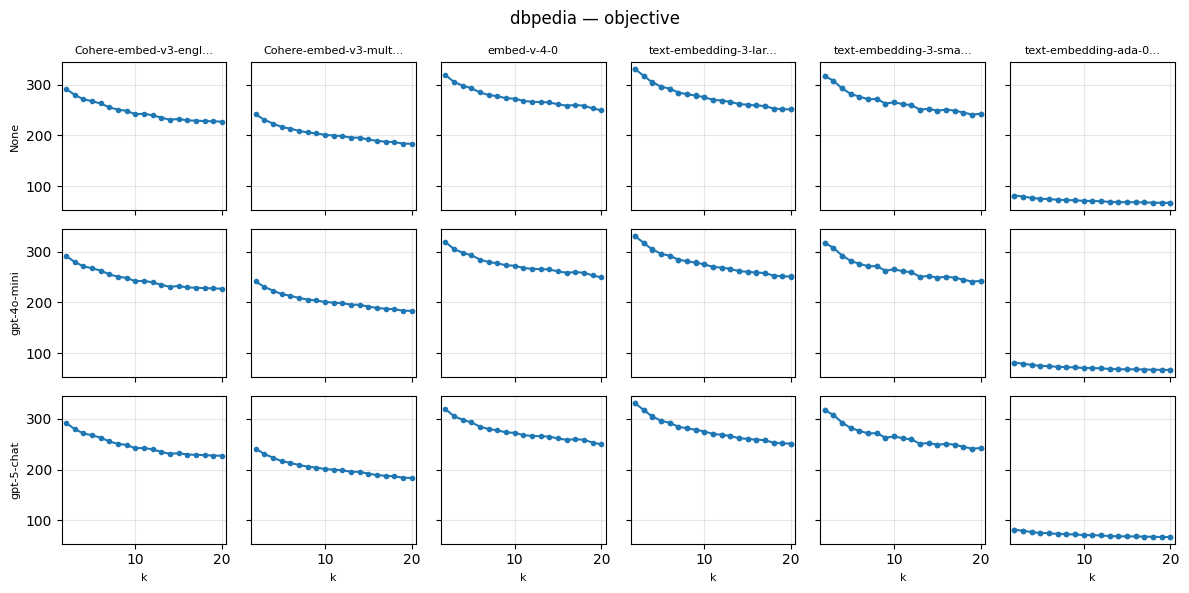

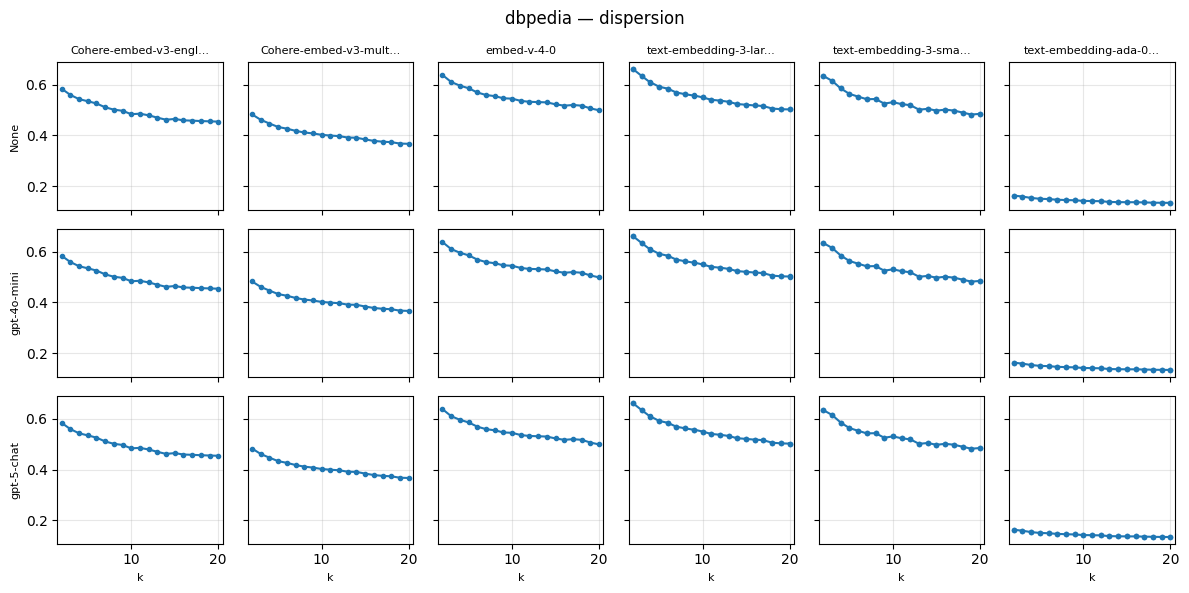

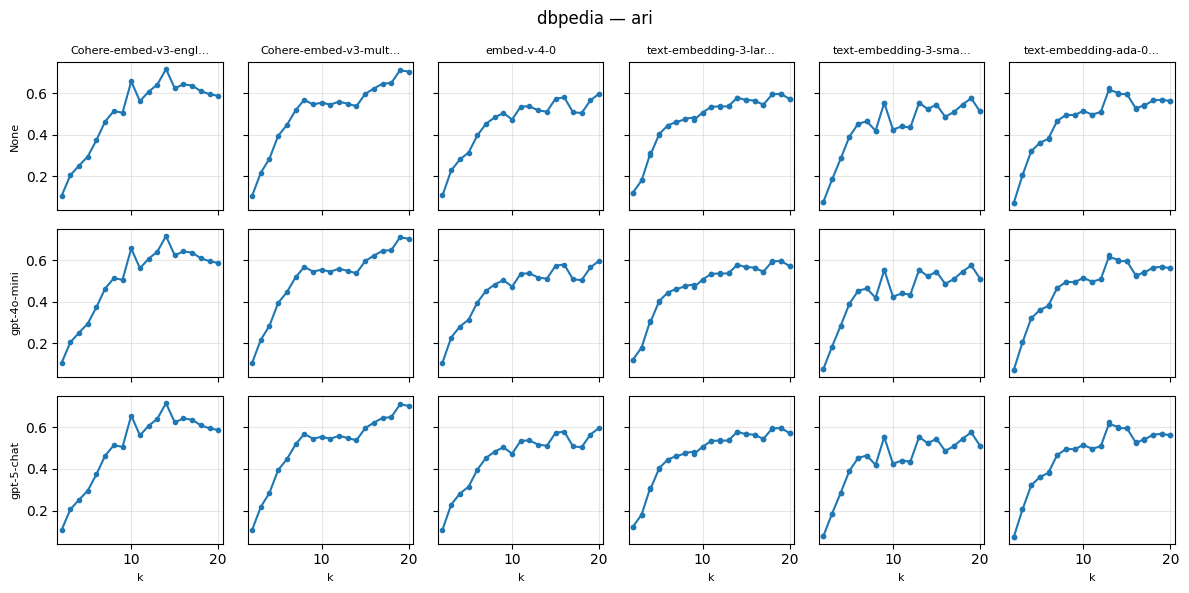

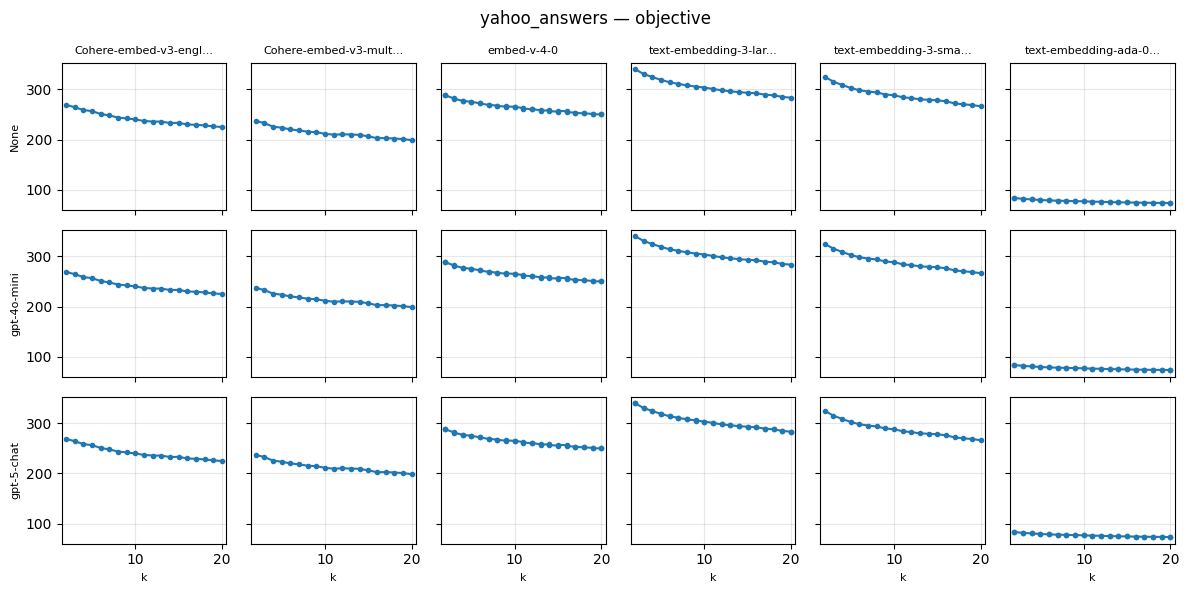

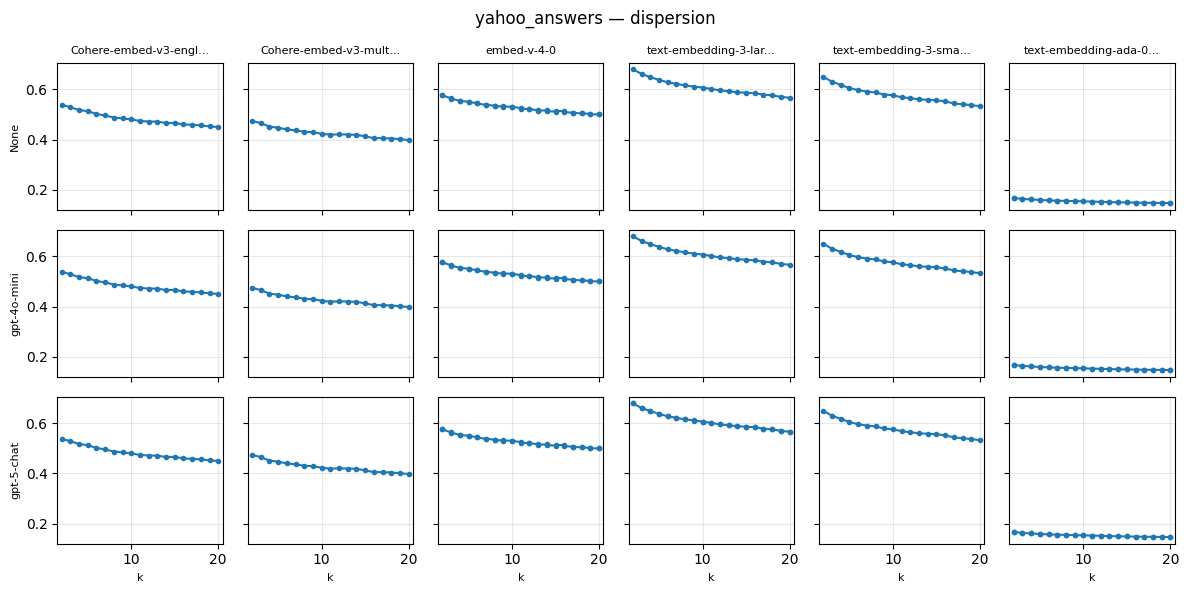

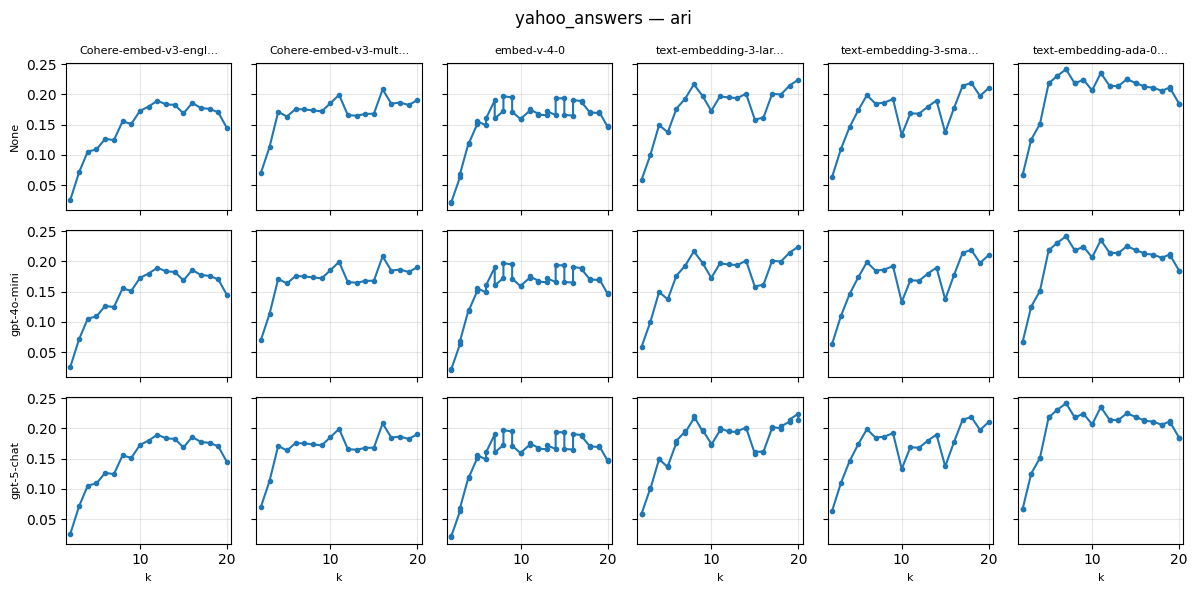

In [9]:
# Plot one subplot grid per (dataset, metric)
import matplotlib.pyplot as plt

if not no_pca_loaded or grid_data is None:
    print("No data to plot. Run the loader and metric extraction cells first.")
else:
    summarizers = grid_data["summarizers"]
    engines = grid_data["engines"]
    by_key = grid_data["by_key"]
    n_rows, n_cols = len(summarizers), len(engines)
    if n_rows == 0 or n_cols == 0:
        print("No summarizers or engines found.")
    else:
        for (dataset, metric_name), series_dict in by_key.items():
            all_vals = []
            for (ks, vals) in series_dict.values():
                all_vals.extend(vals)
            y_min = min(all_vals) if all_vals else 0
            y_max = max(all_vals) if all_vals else 1
            margin = (y_max - y_min) * 0.05 or 0.01
            y_lo = y_min - margin
            y_hi = y_max + margin

            fig, axes = plt.subplots(n_rows, n_cols, figsize=(2 * n_cols, 2 * n_rows), sharex=True, sharey=True)
            if n_rows == 1 and n_cols == 1:
                axes = np.array([[axes]])
            elif n_rows == 1:
                axes = axes.reshape(1, -1)
            elif n_cols == 1:
                axes = axes.reshape(-1, 1)
            fig.suptitle(f"{dataset} — {metric_name}", fontsize=12)
            for i, summarizer in enumerate(summarizers):
                for j, engine in enumerate(engines):
                    ax = axes[i, j]
                    ks, vals = series_dict.get((summarizer, engine), ([], []))
                    if ks and vals:
                        order = np.argsort(ks)
                        ks = [ks[o] for o in order]
                        vals = [vals[o] for o in order]
                        ax.plot(ks, vals, "o-", markersize=3)
                    ax.set_ylim(y_lo, y_hi)
                    ax.set_xlim(1.5, 20.5)
                    ax.grid(True, alpha=0.3)
                    if i == 0:
                        ax.set_title(engine[:20] + ("..." if len(engine) > 20 else ""), fontsize=8)
                    if j == 0:
                        ax.set_ylabel(summarizer if summarizer else "None", fontsize=8)
                    if i == n_rows - 1:
                        ax.set_xlabel("k", fontsize=8)
            plt.tight_layout()
            plt.show()

## Generate plots via script (recommended)

To avoid notebook editing issues, run the standalone script. It loads data, computes all metrics (including silhouette from Z), and saves one PNG per (dataset, metric) under `experimental_results/plots/no_pca_metrics/`.

In [ ]:
# Run from repo root. Plots saved to experimental_results/plots/no_pca_metrics/
import subprocess
import sys
from pathlib import Path
repo = Path('..').resolve()  # parent of notebooks/
data_dir = repo / 'experimental_results'
rc = subprocess.run([sys.executable, 'scripts/plot_no_pca_multi_embedding.py', '--data-dir', str(data_dir)], cwd=repo)
if rc.returncode != 0:
    raise SystemExit(rc.returncode)
print('Plots saved to', data_dir / 'plots' / 'no_pca_metrics')
